The purpose of this class is to contain the code for an individual unmixing run. Images and parameters will be specified here and results will be displayed/saved.

Most of the stuff here was hashed out in the reproduce_gammon_alg.ipynb file.

In [13]:
%%writefile BLUnmixer.py

import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.filters import median_filter
from sklearn.linear_model import LinearRegression
from matplotlib.widgets import EllipseSelector, Button

class BLUnmixer:
    def __init__(self, np_imstack=None):
        self.np_imstack = np_imstack
        self.rois = []
        self.K = None
        self.fitted = None

    def get_ROIs(self, testing=False):
        """
        This actually has to be run separately to work. Threaded implementation would
        be the solution to this in the future.
        """
        if testing:
            self.rois.append(ROISelector(None, coords=np.array([[38.34724799, 81.42245273],
 [47.43628305, 89.1528176 ]])))
            self.rois.append(ROISelector(None, coords=np.array([[186.32273571, 211.08250408],
 [193.65955473, 218.03983246]])))
            return
        for image in self.np_imstack:
            self.rois.append(ROISelector(image))
    
    def crop_ROI(self, roi_selector, image):
        ROI = roi_selector.coords
        x1 = int(np.round(ROI[0,0]))
        x2 = int(np.round(ROI[1,0]))
        y1 = int(np.round(ROI[0,1]))
        y2 = int(np.round(ROI[1,1]))
        return image[y1:y2,x1:x2]
    
    def norm(self, arr):
        n_arr = []
        if len(arr.shape) == 3: # if there are multiple channels
            for i, sl in enumerate(arr):
                n_arr.append((sl-sl.min())/(sl.max()-sl.min()))
        else:
            n_arr = (arr-arr.min())/(arr.max()-arr.min())
        return np.array(n_arr)
    
    def find_K(self, stack):
        K_flat = []
        for image in stack:
            for roi in self.rois:
                mean = np.mean(self.crop_ROI(roi, image))
                K_flat.append(mean)
        self.K = np.array(K_flat).reshape((stack.shape[0],
                                       stack.shape[0]))
        return self.K
    
    def fit(self):
        normd = np.array([self.norm(x) for x in self.np_imstack])
        K = self.find_K(normd)
        K_inv = pinv(K)
        print(K_inv)
        dot = np.dot(K_inv, self.np_imstack.reshape(2,256*256)).reshape(2,256,256)
        self.fitted = dot
        
    def plot_fit(self):
        fig, axs = plt.subplots(nrows=1, ncols=self.fitted.shape[0])
        fig.set_size_inches(10,6)
        for i, ax in enumerate(axs):
            ax.set_title("Channel {}".format(i+1))
            im = ax.imshow(self.fitted[i])
            plt.colorbar(im, ax=ax)

from matplotlib.widgets import EllipseSelector, RectangleSelector
import numpy as np
import matplotlib.pyplot as plt

class ROISelector:
    def __init__(self, image, coords=None):
        self.image = image
        self.coords = coords
        if coords is not None: # then testing
            return
        self.isDone = False
        self.fig, ax = plt.subplots()
        self.widget = RectangleSelector(ax, self._onselect, drawtype='box',
                                             interactive=True,useblit=True)
        axDone = plt.axes([0.81, 0.05, 0.1, 0.075])
        self.doneButton = Button(axDone, 'Done')
        self.doneButton.on_clicked(self.done)
        
        ax.imshow(self.image)
        plt.connect('key_press_event', self.widget)
        plt.show()
        
    def _onselect(self, pt1, pt2):
        #print(self.widget.geometry) # this will actually give the coords of each
        # point around the ellipse
        self.coords = np.array([[pt1.xdata, pt1.ydata],[pt2.xdata, pt2.ydata]])
        #print(self.coords)
    
    def done(self, event):
        self.isDone = True
        plt.close(self.fig)
        #print('Done!')
        
    def get_coords(self):
        return self.coords

Overwriting BLUnmixer.py


In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
%run BLUnmixer.py

# test out some code for getting the rois:
bromo = plt.imread('5386_4Br.TIF')
dluc = plt.imread('5386_dluc.TIF')

In [17]:
test = BLUnmixer(np_imstack=np.array([bromo, dluc]))

test.get_ROIs(testing=True)

[[ 3.62166176 -0.10908338]
 [-0.20263671  1.55219233]]


<IPython.core.display.Javascript object>


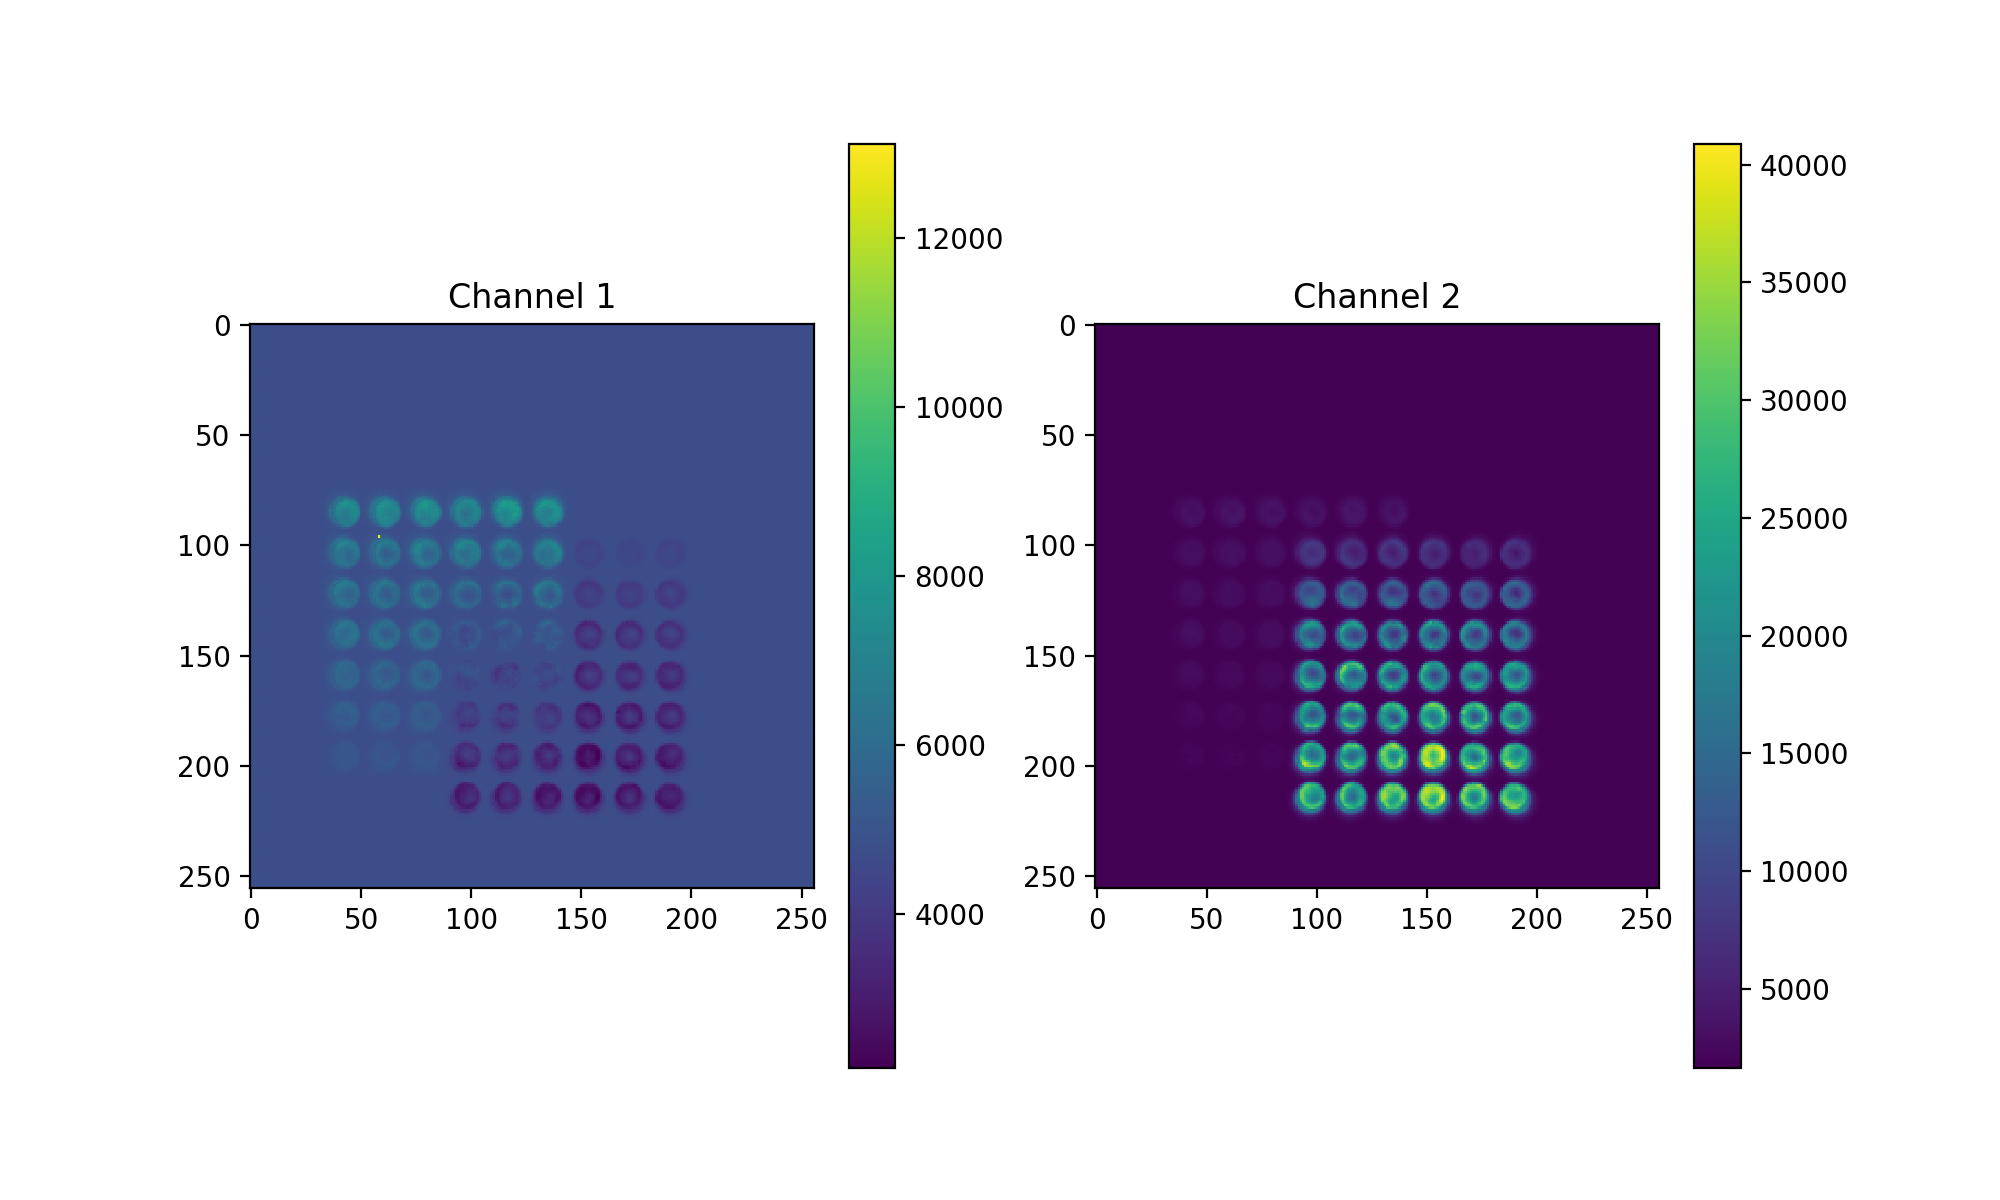

In [18]:
test.fit()
test.plot_fit()

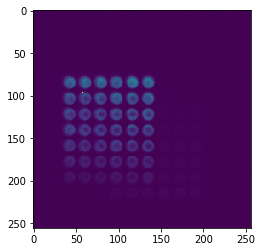

In [4]:
plt.imshow(bromo)

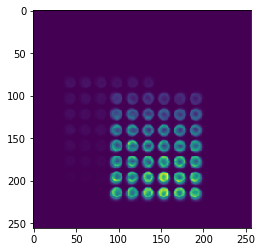

In [5]:
plt.imshow(dluc)

**Not sure what's going wrong here. Test if the ROIs are getting passed correctly? Test if algorithm matches that in the reproduce_alg file?**